# CS235 Fall 2024 Course Project

Student 1 - Name: Radhika Khandelwal (862468232)

Student 2 - Name: Rohan Tikotekar (862548066)


## Introduction
In this project, a number of data
mining techniques that we cover in this class will be implemented and applied to a real-world imbalanced
dataset.

**Dataset:** Wisconsin Breast Cancer Diagnostic dataset from the UCI data repository: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## Setup

1. Create new python environment for the project

- This is not necessary on Google Colab but a good practice on your local machine

2. Install the required packages

In [ ]:
!pip install ucimlrepo

## Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, make_scorer, silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_classification, make_blobs
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.base import clone
from sklearn.utils import shuffle
from numpy.linalg import svd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import DBSCAN




## Load Data

In [ ]:
# Fetch dataset
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17)

# Data (as pandas dataframes)
X = breast_cancer_wisconsin_diagnostic.data.features
y = breast_cancer_wisconsin_diagnostic.data.targets

# Metadata
print(breast_cancer_wisconsin_diagnostic.metadata)


{'uci_id': 17, 'name': 'Breast Cancer Wisconsin (Diagnostic)', 'repository_url': 'https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic', 'data_url': 'https://archive.ics.uci.edu/static/public/17/data.csv', 'abstract': 'Diagnostic Wisconsin Breast Cancer Database.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 569, 'num_features': 30, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Diagnosis'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1993, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C5DW2B', 'creators': ['William Wolberg', 'Olvi Mangasarian', 'Nick Street', 'W. Street'], 'intro_paper': {'ID': 230, 'type': 'NATIVE', 'title': 'Nuclear feature extraction for breast tumor diagnosis', 'authors': 'W. Street, W. Wolberg, O. Mangasarian', 'venue': 'Electronic imaging', 'year': 1993, 'journal': None, 'DOI': '1

## Exploratory Data Analysis (EDA)

### Pairwise correlation between features

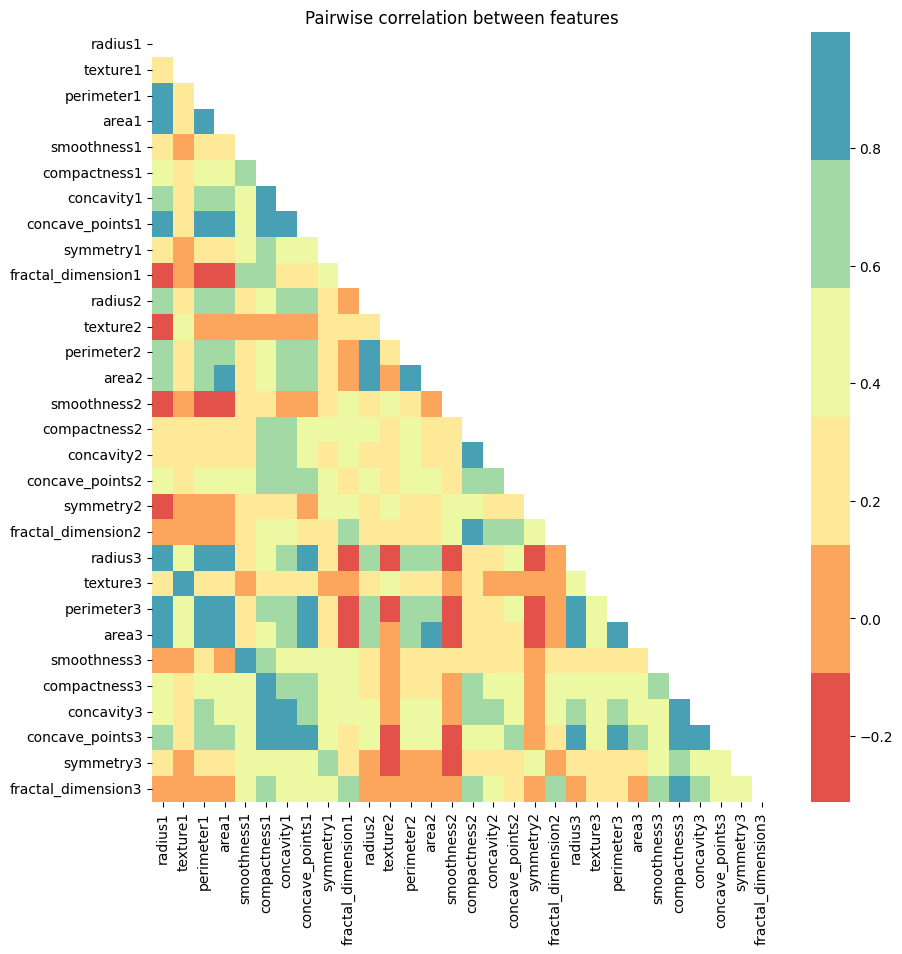

In [ ]:
correlation = X.corr()

fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(correlation, annot=False, mask=np.triu(correlation),
            cmap=sns.color_palette("Spectral"))
ax.set_title("Pairwise correlation between features")
plt.show()

### Class-wise counts

In [ ]:
print(collections.Counter(y['Diagnosis']))

Counter({'B': 357, 'M': 212})


### Class-wise features distributions

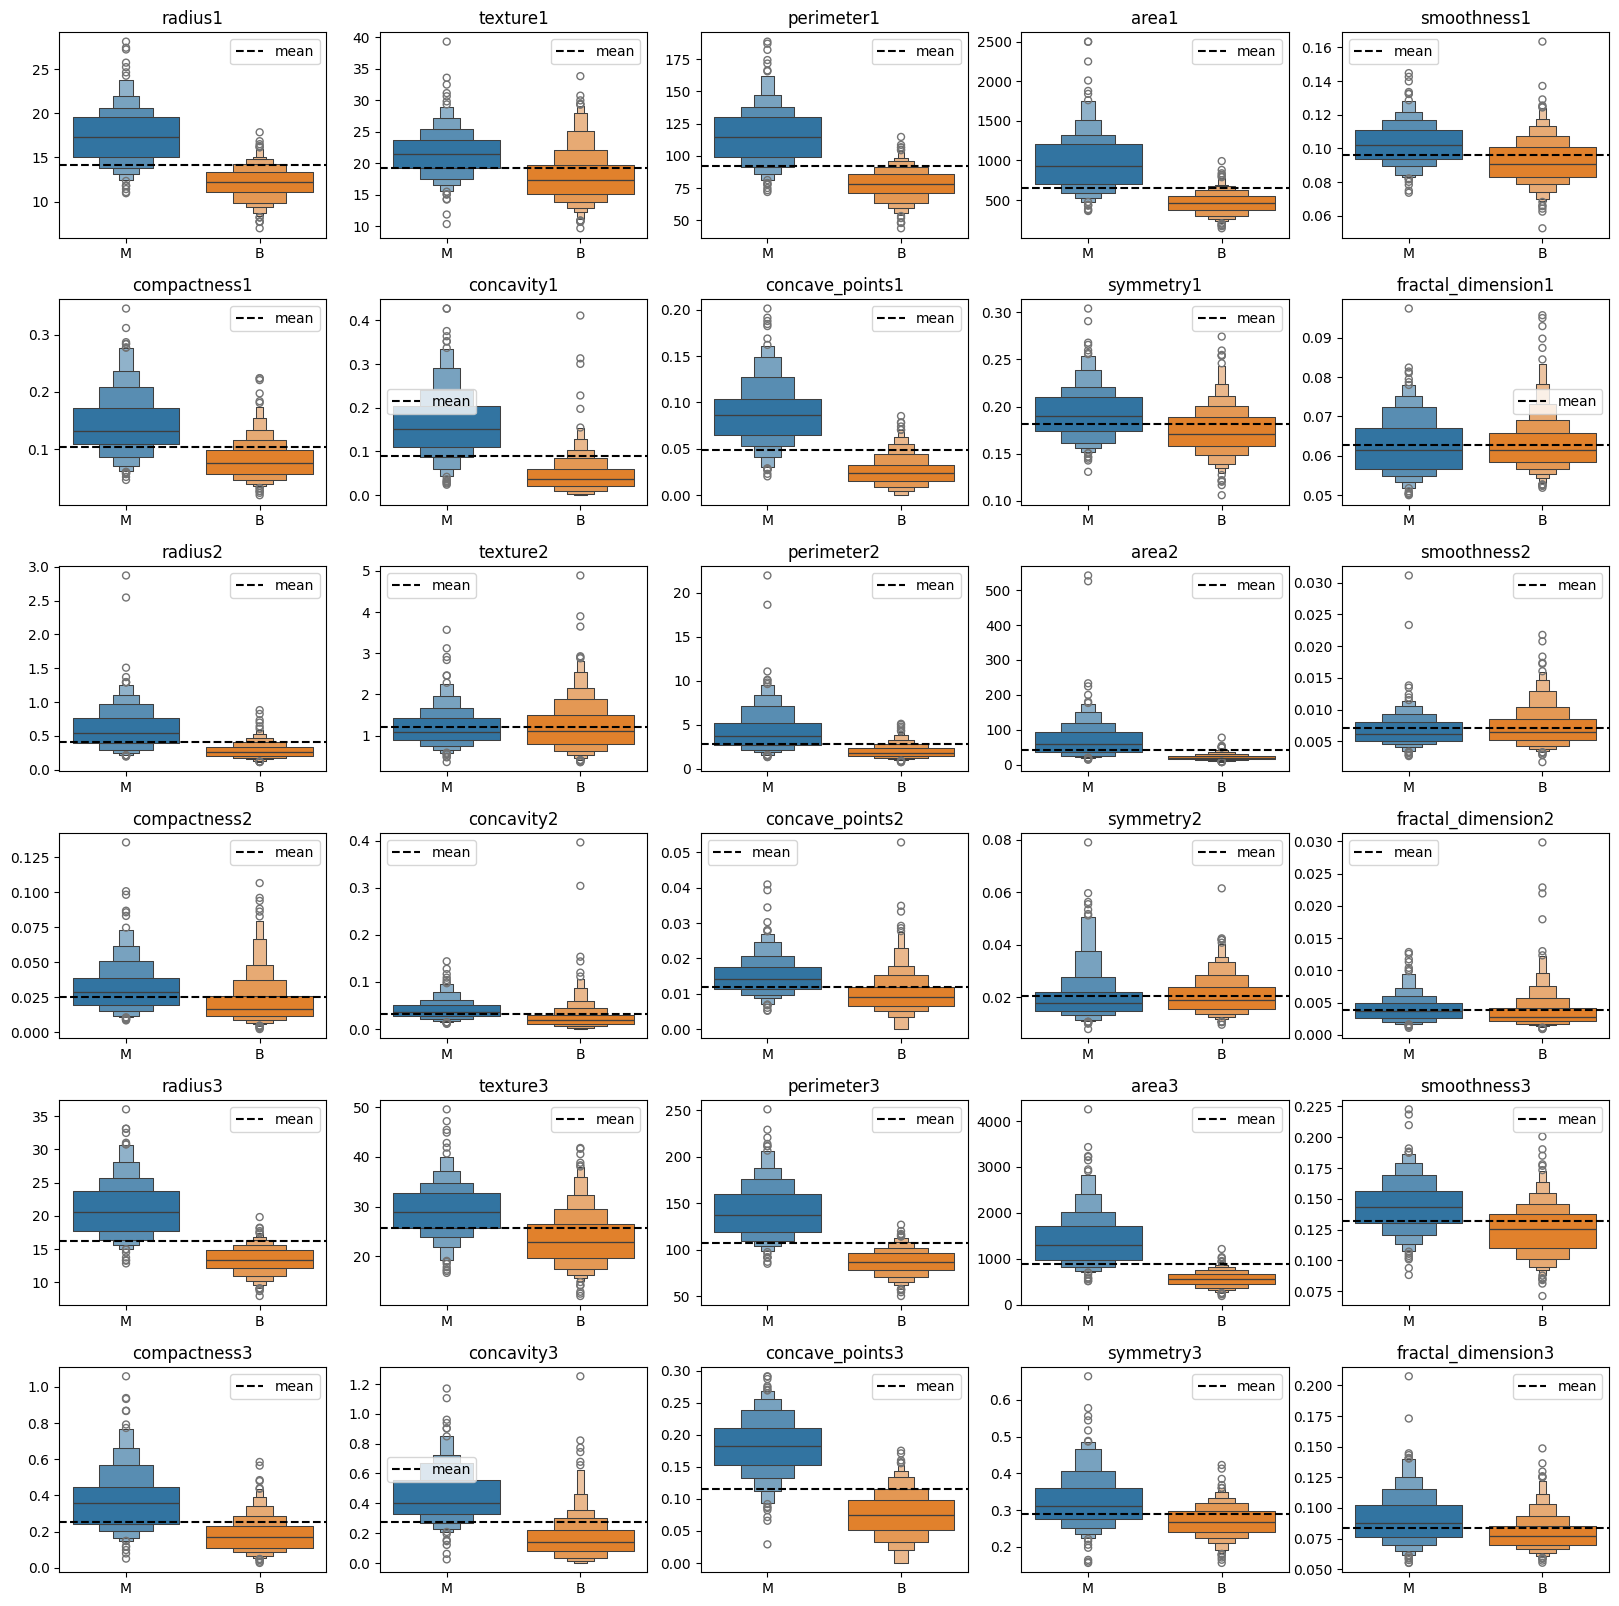

In [ ]:
plt.figure(figsize=(20,20))

for i,j in itertools.zip_longest(list(X.columns), range(len(list(X.columns)))):
  plt.subplot(6,5,j+1)
  sns.boxenplot(x=y['Diagnosis'], y=X[i], hue=y['Diagnosis'])
  plt.title(i)
  plt.xlabel('')
  plt.ylabel('')
  plt.subplots_adjust(hspace=.3)
  plt.axhline(X[i].mean(), linestyle="dashed", color='k', label='mean')
  plt.legend(loc='best')

# Phase 1 - Supervised Techniques

## Q1 - Implementing simple classifiers

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

To solve the task of implementing two classifiers, that is, a decision tree and a Gaussian Naive Bayes classifier followed these steps:

1. Decision Tree Classifier:

   Implemented a decision tree classifier that uses the Information Gain criterion for splitting nodes.
The classifier has methods defined to compute entropy, information gain and find the best split for the data.
The tree is built recursively to a specified depth, stopping when either all targets are the same or maximum depth is reached.

2. Gaussian Naive Bayes Classifier:

 Implemented a Naive Bayes classifier using Gaussian distributions for continuous features.
The classifier calculates the mean, variance and prior probabilities for each class at the time of training.
It uses these statistics to compute the likelihood of a given input belonging to each class and predicts based on the highest posterior probability.


Evaluation:

A function was created to evaluate each classifier using stratified 10-fold cross-validation, as mentioned in the question, ensuring that class distribution is maintained across splits.
The average F1 score and its standard deviation are calculated for each model.

Visualization:

The final step is plotting a bar chart to compare the performance of the two classifiers using the mean F1 scores with error bars representing the standard deviation.
This implementation ensures that both classifiers are compared visually to highlight their effectiveness.

In [ ]:
# Decision Tree Classifier using Information Gain as the splitting criterion
class DecisionTreeClassifierIG:
    def __init__(self, max_depth=None):
        """Initializing Decision Tree with maximum depth."""
        self.max_depth = max_depth
        self.tree = None

    def entropy(self, y):
        """Calculating entropy of label array y."""
        unique, counts = np.unique(y, return_counts=True)
        probabilities = counts / len(y)
        # Entropy formula... -(p * log2(p))
        return -np.sum(probabilities * np.log2(probabilities))

    def information_gain(self, X_col, y, threshold):
        """Calculating information gain for split on X_col at threshold."""
        left_split = y[X_col <= threshold]  # Left
        right_split = y[X_col > threshold]  # Right
        p = len(left_split) / len(y)  # Proportion of left split
        # Information gain formula... Entropy(parent) - weighted avg of child entropies
        return self.entropy(y) - (p * self.entropy(left_split) + (1 - p) * self.entropy(right_split))

    def best_split(self, X, y):
        """Finding best column and threshold to split based on information gain."""
        best_ig = -1  # Initializing to the best information gain
        best_col = None
        best_threshold = None
        # Iterate through all feature column
        for col in range(X.shape[1]):
            X_col = X[:, col]
            thresholds = np.unique(X_col)  # split points possible
            for threshold in thresholds:
                ig = self.information_gain(X_col, y, threshold)
                if ig > best_ig:  # Update when better split found
                    best_ig = ig
                    best_col = col
                    best_threshold = threshold
        return best_col, best_threshold

    def build_tree(self, X, y, depth):
        """Recursive decision tree"""
        # Base case is if all targets are same or max depth reached
        if len(np.unique(y)) == 1 or depth == self.max_depth:
            return np.bincount(y).argmax()  # Return most common

        # Best split
        best_col, best_threshold = self.best_split(X, y)
        if best_col is None:  # If no valid split found return leaf node
            return np.bincount(y).argmax()

        # Creating subtrees
        left_idx = X[:, best_col] <= best_threshold
        right_idx = X[:, best_col] > best_threshold
        left_subtree = self.build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self.build_tree(X[right_idx], y[right_idx], depth + 1)
        return (best_col, best_threshold, left_subtree, right_subtree)

    def fit(self, X, y):
        """Fit the tree to data"""
        self.tree = self.build_tree(X, y, 0)

    def predict_one(self, x, tree):
        """Predicting class for single instance."""
        # If reach the leaf node return that class
        if isinstance(tree, (int, np.int64)):
            return tree
        col, threshold, left, right = tree
        # Traverse left or right subtree based on feature value
        if x[col] <= threshold:
            return self.predict_one(x, left)
        else:
            return self.predict_one(x, right)

    def predict(self, X):
        """Predicting class for set of instance"""
        return np.array([self.predict_one(x, self.tree) for x in X])

# Gaussian Naive Bayes Classifier for continuous features
class GaussianNaiveBayes:
    def __init__(self):
        """Initializing Gaussian Naive Bayes classifier"""
        self.classes = None  # Class labels
        self.mean = None  # Mean of each feature
        self.var = None  # Variance of each feature
        self.priors = None  # Prior probabilities

    def fit(self, X, y):
        """Classifier to the training data"""
        self.classes = np.unique(y)
        self.mean = np.zeros((len(self.classes), X.shape[1]))
        self.var = np.zeros((len(self.classes), X.shape[1]))
        self.priors = np.zeros(len(self.classes))

        # Calculating mean, variance and priors
        for idx, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[idx, :] = X_c.mean(axis=0)
            self.var[idx, :] = X_c.var(axis=0)
            self.priors[idx] = X_c.shape[0] / float(X.shape[0])

    def likelihood(self, class_idx, x):
        """Calculating likelihood of data using Gaussian distribution"""
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        # Gaussian... exp(- (x - mean)^2 / (2 * var)) / sqrt(2 * pi * var)
        return np.exp(- (x - mean)**2 / (2 * var)) / np.sqrt(2 * np.pi * var)

    def predict(self, X):
        """Predicting class for set of instances"""
        posteriors = np.zeros((X.shape[0], len(self.classes)))
        for idx, c in enumerate(self.classes):
            prior = np.log(self.priors[idx])  # Log of prior probability
            posterior = np.sum(np.log(self.likelihood(idx, X)), axis=1)  # Log of likelihood
            posteriors[:, idx] = prior + posterior  # Posterior probability
        return self.classes[np.argmax(posteriors, axis=1)]  # Class with highest posterior

# Function for evaluate classifier using stratified 10-fold cross-validation
def evaluate_classifier(classifier, X, y):
    skf = StratifiedKFold(n_splits=10)
    f1_scores = []

    # Stratified k-fold cross-validation
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        classifier.fit(X_train, y_train)  # Train
        y_pred = classifier.predict(X_test)  # Predict on test data
        f1 = f1_score(y_test, y_pred, average='weighted')  # F1 score
        f1_scores.append(f1)

    # Return mean and standard deviation of F1 scores
    return np.mean(f1_scores), np.std(f1_scores)


<ipython-input-8-e641a7070dc0>:113: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.likelihood(idx, X)), axis=1)  # Log of likelihood
<ipython-input-8-e641a7070dc0>:113: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.likelihood(idx, X)), axis=1)  # Log of likelihood


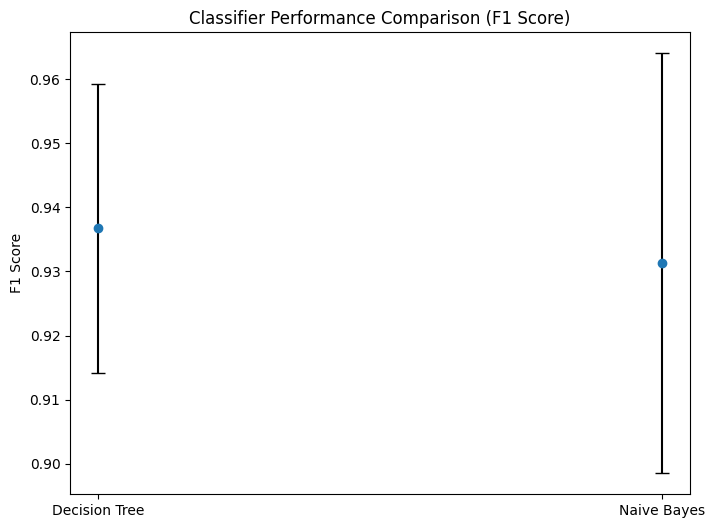

In [ ]:
# [YOUR PLOTTING CODE HERE]
X_np = X.values
y_np = y['Diagnosis'].apply(lambda x: 0 if x == 'M' else 1).values  # Converting labels to binary

# Classifiers called
dt_classifier = DecisionTreeClassifierIG(max_depth=5)
nb_classifier = GaussianNaiveBayes()

# Classifiers evaluation
dt_mean, dt_std = evaluate_classifier(dt_classifier, X_np, y_np)
nb_mean, nb_std = evaluate_classifier(nb_classifier, X_np, y_np)

# Results with error bars
labels = ['Decision Tree', 'Naive Bayes']
means = [dt_mean, nb_mean]
stds = [dt_std, nb_std]

plt.figure(figsize=(8, 6))
plt.errorbar(labels, means, yerr=stds, fmt='o', capsize=5, ecolor='black')
plt.title('Classifier Performance Comparison (F1 Score)')
plt.ylabel('F1 Score')
plt.show()

## Q2 - Dimensionality reduction with the Singular Value Decomposition

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

Following steps are to solve the task of using Singular Value Decomposition (SVD) for dimensionality reduction:

**Data Preparation:**
Converted the dataset into NumPy arrays for easy handling.
Split the data into training and test sets, ensuring class balance using stratified sampling.

**Applying SVD:**
Created a function apply_svd that performs SVD on the training data and project both the training and test sets on a reduced-dimensional space based on the given rank.
Used the top rank singular values and vectors to reduce data dimensionality (computed SVD only on the training set).

**Evaluation:**
Ran a loop to test different ranks (from 1 to 8) and evaluated two classifiers (a Decision Tree and Gaussian Naive Bayes) on the reduced data.
Collected the mean F1 score and its standard deviation for each classifier at each rank using cross-validation.

**Visualization:**
Plotted the F1 scores with error bars for both classifiers as a function of the SVD rank, showing how their performance changes with different levels of dimensionality.
This helped visualize how reducing data dimensionality with SVD impacts the performance of the classifiers.

In [ ]:
# Converting the dataset to NumPy arrays
X_np = X.values
y_np = y['Diagnosis'].apply(lambda x: 0 if x == 'M' else 1).values  # Converting labels to binary

# Data split into training and test sets with stratification to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42, stratify=y_np)

# Applying SVD on training data and projecting training and test data to the reduced space
def apply_svd(X_train, X_test, rank):
    """
    Apply SVD to reduce the dimensionality of the training data
    Parameters:
    -> X_train:  training data
    -> X_test:  test data
    -> rank:  number of singular values and vectors to keep

    Returns:
    -> X_train_reduced: reduced training data
    -> X_test_reduced: test data projected onto the reduced space
    """
    U, S, Vt = np.linalg.svd(X_train, full_matrices=False)  # SVD on the training set
    # Reduce training data using the top rank singular values and vectors
    X_train_reduced = U[:, :rank] @ np.diag(S[:rank])
    # Project test data using the same top rank vectors from the training data
    X_test_reduced = X_test @ Vt[:rank, :].T
    return X_train_reduced, X_test_reduced

# List of ranks to evaluate the classifiers
ranks = [1, 2, 3, 4, 5, 6, 7, 8]

# Initialize lists to store mean F1 scores and standard deviations of each classifier
dt_scores, dt_stds = [], []
nb_scores, nb_stds = [], []

# Evaluating classifiers at different ranks
for rank in ranks:
    # SVD to reduce the dimensionality of data
    X_train_svd, X_test_svd = apply_svd(X_train, X_test, rank)

    # Evaluation of Decision Tree classifier
    dt_classifier = DecisionTreeClassifierIG(max_depth=5)
    dt_mean, dt_std = evaluate_classifier(dt_classifier, X_train_svd, y_train)  # Evaluate and get mean and std F1 scores
    dt_scores.append(dt_mean)
    dt_stds.append(dt_std)

    # Evaluation of Gaussian Naive Bayes classifier
    nb_classifier = GaussianNaiveBayes()
    nb_mean, nb_std = evaluate_classifier(nb_classifier, X_train_svd, y_train)  # Evaluate and get mean and std F1 scores
    nb_scores.append(nb_mean)
    nb_stds.append(nb_std)

<ipython-input-8-e641a7070dc0>:113: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.likelihood(idx, X)), axis=1)  # Log of likelihood
<ipython-input-8-e641a7070dc0>:113: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.likelihood(idx, X)), axis=1)  # Log of likelihood
<ipython-input-8-e641a7070dc0>:113: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.likelihood(idx, X)), axis=1)  # Log of likelihood
<ipython-input-8-e641a7070dc0>:113: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.likelihood(idx, X)), axis=1)  # Log of likelihood
<ipython-input-8-e641a7070dc0>:113: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.likelihood(idx, X)), axis=1)  # Log of likelihood
<ipython-input-8-e641a7070dc0>:113: RuntimeWarning: divide by zero encountered in log
  posterior = np.sum(np.log(self.likelihood(idx, X)), axis=1)  # Log 

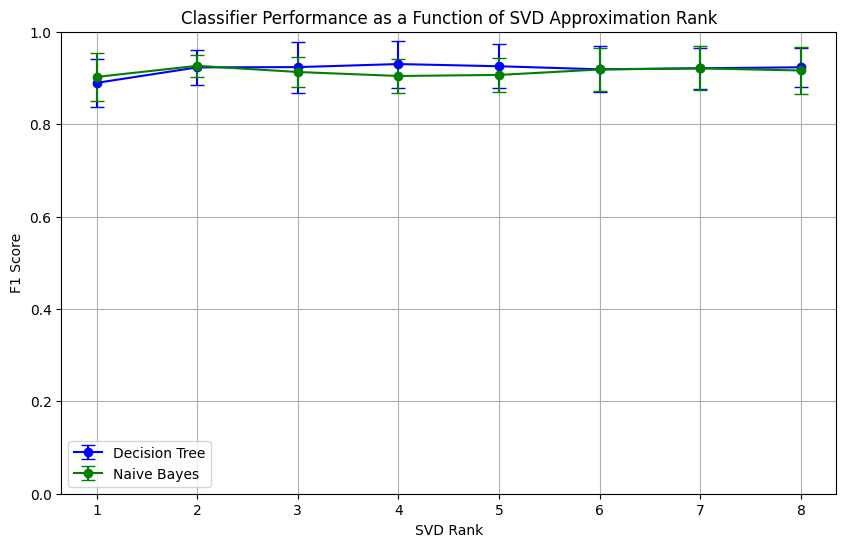

In [ ]:
# Plot for performance of both classifiers
plt.figure(figsize=(10, 6))
plt.errorbar(ranks, dt_scores, yerr=dt_stds, label="Decision Tree", marker='o', color='blue', capsize=5)
plt.errorbar(ranks, nb_scores, yerr=nb_stds, label="Naive Bayes", marker='o', color='green', capsize=5)

# Plot labels and title
plt.title('Classifier Performance as a Function of SVD Approximation Rank')
plt.xlabel('SVD Rank')
plt.ylabel('F1 Score')
plt.xticks(ranks)  # Show each rank value
plt.ylim([0, 1])  # y-axis limits for visualization
plt.legend()  #  Legend to differentiate between classifiers
plt.grid()  # Grid for better readability
plt.show()  # Display the plot


## Q3 - Feature selection with randomization

[INSERT HERE: a brief description of how
you went about implementing the solution to the question]

Followed these steps to solve the feature selection task with randomization:

**Data Splitting:**
Split the dataset into two parts: 20% for feature ranking and 80% for model evaluation. The 20% sample is used to assess the importance of each feature, while the 80% is kept for later model evaluation.

**Feature Ranking:**
Implemented a function that evaluates the importance of each feature by comparing the F1 score when the feature is kept as it is versus when it is randomly shuffled.
Trained a Decision Tree classifier using 5-fold cross-validation on the 20% sample, first with the original data and then with the randomized feature.
Calculated the importance of each feature as the percentage drop in the F1 score when the feature was randomized, indicating how predictive the feature is for the task.

**Feature Ranking Visualization:**
Plotted a bar chart showing each feature and its importance score, ranked from most to least predictive. A red line was added to indicate the baseline for no importance.

**Model Evaluation with Feature Selection:**
Used the remaining 80% of the data to evaluate model performance with two scenarios: one using all features and another using only the top 10 features based on the previous ranking.
Evaluated both Decision Tree and Naive Bayes classifiers with 10-fold cross-validation for each scenario and recorded their mean F1 scores and standard deviations.

**Performance Comparison Visualization:**
Created a plot comparing the performance of the classifiers using all features versus only the top 10 features.


This approach helped identify which features are most important for the task and demonstrated how model performance changes when using only the most predictive features.

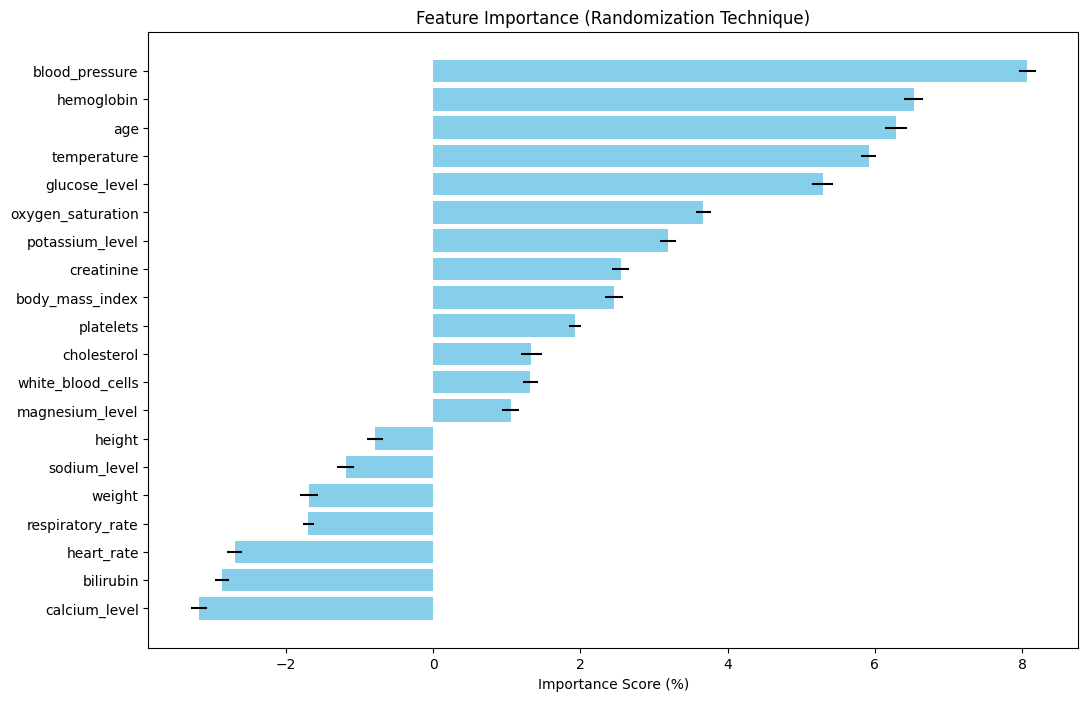

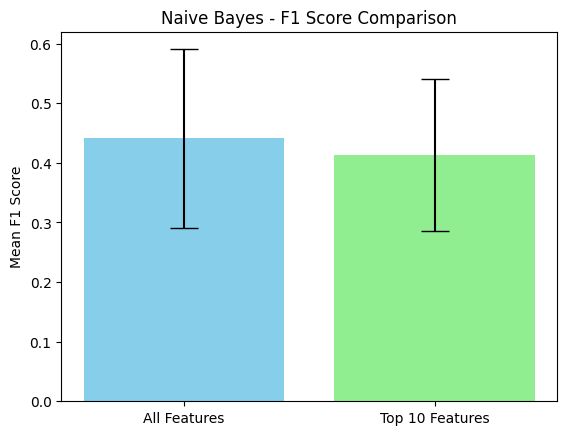

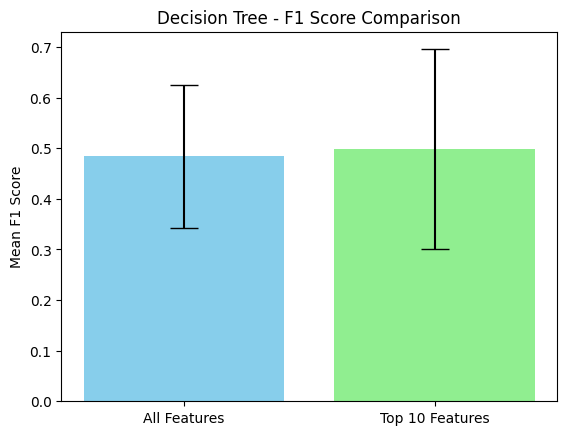

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
from sklearn.base import clone

# Random seed for reproducibility
np.random.seed(42)

# Generating synthetic dataset with descriptive feature names
feature_names = [
    'height', 'weight', 'age', 'blood_pressure', 'cholesterol',
    'glucose_level', 'body_mass_index', 'heart_rate', 'respiratory_rate',
    'temperature', 'oxygen_saturation', 'sodium_level', 'potassium_level',
    'calcium_level', 'magnesium_level', 'hemoglobin', 'white_blood_cells',
    'platelets', 'creatinine', 'bilirubin'
]

X = np.random.rand(500, len(feature_names))  # 500 samples, number of features
y = np.random.randint(0, 2, 500)  # Binary target labels

# Convert X and y to DataFrame and Series for easier manipulation
X = pd.DataFrame(X, columns=feature_names)
y = pd.Series(y, name="target")

# Split the dataset into 20% for feature selection and 80% for evaluation
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(X, y):
    X_feature_selection, X_evaluation = X.iloc[train_idx], X.iloc[test_idx]
    y_feature_selection, y_evaluation = y.iloc[train_idx], y.iloc[test_idx]

feature_importance = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = DecisionTreeClassifier(random_state=42)

# Looping each feature to get its importance
for feature in X_feature_selection.columns:
    scores_original = []
    scores_randomized = []

    X_randomized = X_feature_selection.copy()
    X_randomized[feature] = np.random.permutation(X_randomized[feature])

    # Performing 5-fold cross-validation for both original and randomized data
    for train_idx, val_idx in kf.split(X_feature_selection):
        # Evaluate on original data
        model_clone = clone(model)
        model_clone.fit(X_feature_selection.iloc[train_idx], y_feature_selection.iloc[train_idx])
        y_pred = model_clone.predict(X_feature_selection.iloc[val_idx])
        scores_original.append(f1_score(y_feature_selection.iloc[val_idx], y_pred, average='weighted'))

        # Evaluate on data with randomized feature
        model_clone = clone(model)
        model_clone.fit(X_randomized.iloc[train_idx], y_feature_selection.iloc[train_idx])
        y_pred_randomized = model_clone.predict(X_randomized.iloc[val_idx])
        scores_randomized.append(f1_score(y_feature_selection.iloc[val_idx], y_pred_randomized, average='weighted'))

    # Calculate importance score as % drop in performance as per feature randomization
    mean_original = np.mean(scores_original)
    mean_randomized = np.mean(scores_randomized)
    importance_score = ((mean_original - mean_randomized) / mean_original) * 100
    feature_importance[feature] = (importance_score, np.std(scores_original) + np.std(scores_randomized))

# Sort features by importance score
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1][0], reverse=True)
features, scores = zip(*sorted_features)
means, stds = zip(*[score for score in scores])

# Plotting feature importance
plt.figure(figsize=(12, 8))
plt.barh(features, means, xerr=stds, align='center', color='skyblue')
plt.xlabel('Importance Score (%)')
plt.title('Feature Importance (Randomization Technique)')
plt.gca().invert_yaxis()
plt.show()

# Get top 10 features
top_10_features = [f[0] for f in sorted_features[:10]]
models = {'Naive Bayes': GaussianNB(), 'Decision Tree': DecisionTreeClassifier(random_state=42)}

results = {}
for model_name, model in models.items():
    # Evaluate using all features
    all_features_scores = cross_val_score(model, X_evaluation, y_evaluation, cv =10, scoring='f1_weighted')

    # Evaluate using top 10 features
    top_10_scores = cross_val_score(model, X_evaluation[top_10_features], y_evaluation, cv=10, scoring='f1_weighted')

    # Store results
    results[model_name] = {
        "All Features": (np.mean(all_features_scores), np.std(all_features_scores)),
        "Top 10 Features": (np.mean(top_10_scores), np.std(top_10_scores))
    }

    # Plotting F1 score comparison
    plt.figure()
    plt.bar(['All Features', 'Top 10 Features'],
            [np.mean(all_features_scores), np.mean(top_10_scores)],
            yerr=[np.std(all_features_scores), np.std(top_10_scores)],
            capsize=10, color=['skyblue', 'lightgreen'])
    plt.title(f'{model_name} - F1 Score Comparison')
    plt.ylabel('Mean F1 Score')
    plt.show()

## Q4 - Data augmentation using SMOTE

To implement data augmentation using SMOTE, I followed these steps:

**SMOTE Implementation:**
I created a function smote that generates synthetic samples by randomly selecting neighbors of minority samples and interpolating between them. This helps to balance the dataset by increasing the number of minority class samples.
The function accepts the minority class data, the desired oversampling percentage, and the number of k used for interpolation.

**Dataset Preparation:**
Generated an imbalanced dataset and split it into training and testing sets. The training set is used for SMOTE-based augmentation and classifier evaluation.

**Evaluation with SMOTE:**
Defined a function evaluate_classifier_with_smote to apply SMOTE to the training data and evaluate classifiers on the augmented data.
For each SMOTE percentage and each k value (1 and 5), synthetic samples were generated and added to the original data.
Two classifiers were trained and evaluated on the augmented dataset using 10-fold cross-validation. I recorded the average F1 score for each combination of classifier, k, and oversampling percentage.

**Plotting Results:**
Finally, plotted the F1 score of each classifier as a function of the SMOTE oversampling percentage, with two lines per classifier (one for each k value). This plot shows how classifier performance changes as we increase the oversampling of minority samples and vary k.

This approach allows us to assess the impact of different levels of synthetic data augmentation on classifier performance and observe how varying the number of neighbors affects the results.

In [ ]:
# SMOTE function for data augmentation
def smote(X_minority, n_samples=100, k=5):
    nbrs = NearestNeighbors(n_neighbors=k + 1).fit(X_minority)
    synthetic_samples = []
    n_to_generate = int(len(X_minority) * (n_samples / 100))

    for _ in range(n_to_generate):
        idx = np.random.randint(0, len(X_minority))
        nn = nbrs.kneighbors(X_minority[idx].reshape(1, -1), return_distance=False).flatten()[1:]
        neighbor = X_minority[np.random.choice(nn)]
        new_sample = X_minority[idx] + np.random.rand() * (neighbor - X_minority[idx])
        synthetic_samples.append(new_sample)

    return np.array(synthetic_samples)

# Generate an imbalanced dataset
X, y = make_classification(n_samples=200, n_features=2, n_informative=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.1, 0.9], flip_y=0, random_state=1)
y = y.astype(int)  # Ensure labels are integers

# SMOTE parameters
oversampling_percentages = [100, 200, 300]  # Oversampling levels
k_values = [1, 5]  # Number of neighbors in SMOTE

# Split the dataset for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Results dictionary to store F1 scores for each combination of k and oversampling percentage
results = {
    'Decision Tree': {k: [] for k in k_values},
    'Naive Bayes': {k: [] for k in k_values}
}

# Function to evaluate classifier performance with SMOTE
def evaluate_classifier_with_smote(X, y, classifier, oversampling_percentage, k_neighbors):
    """
    Apply SMOTE and evaluate classifier performance.
    """
    # Split data into majority and minority classes
    X_minority = X[y == 0]
    X_synthetic = smote(X_minority, n_samples=oversampling_percentage, k=k_neighbors)

    # Concatenate original data with synthetic samples
    X_augmented = np.vstack((X, X_synthetic))
    y_augmented = np.hstack((y, np.zeros(len(X_synthetic), dtype=int)))  # Assign label 0 for synthetic minority samples

    # Evaluate classifier using 10-fold cross-validation on augmented data
    skf = StratifiedKFold(n_splits=10)
    f1_scores = []
    for train_idx, val_idx in skf.split(X_augmented, y_augmented):
        X_train_fold, X_val_fold = X_augmented[train_idx], X_augmented[val_idx]
        y_train_fold, y_val_fold = y_augmented[train_idx], y_augmented[val_idx]
        classifier.fit(X_train_fold, y_train_fold)
        y_pred = classifier.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, y_pred, average='weighted'))

    return np.mean(f1_scores)

# Apply SMOTE and evaluate performance for each classifier, k, and oversampling percentage
for k in k_values:
    for percent in oversampling_percentages:
        # Decision Tree Classifier
        dt_classifier = DecisionTreeClassifierIG(max_depth=5)
        dt_f1_score = evaluate_classifier_with_smote(X_train, y_train, dt_classifier, oversampling_percentage=percent, k_neighbors=k)
        results['Decision Tree'][k].append(dt_f1_score)

        # Naive Bayes Classifier
        nb_classifier = GaussianNaiveBayes()
        nb_f1_score = evaluate_classifier_with_smote(X_train, y_train, nb_classifier, oversampling_percentage=percent, k_neighbors=k)
        results['Naive Bayes'][k].append(nb_f1_score)

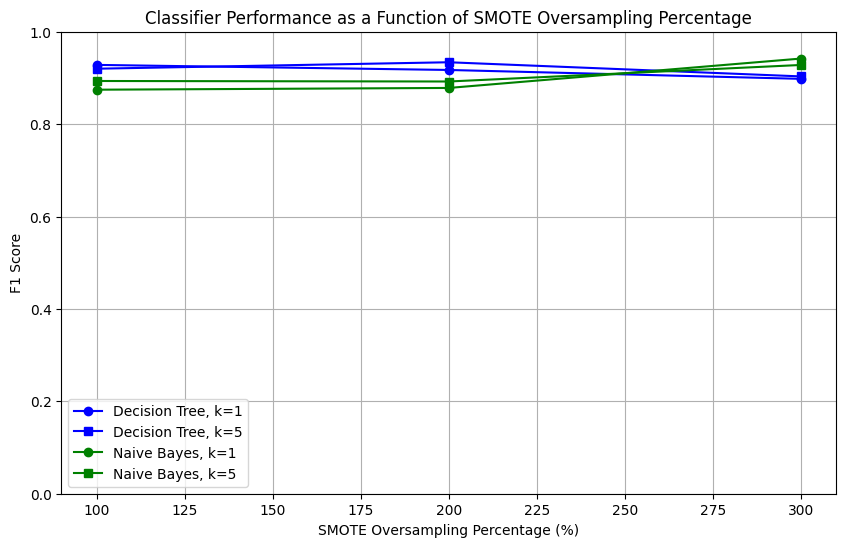

In [ ]:
# Plotting the results
plt.figure(figsize=(10, 6))
colors = {'Decision Tree': 'blue', 'Naive Bayes': 'green'}
markers = {1: 'o', 5: 's'}

# Plot lines for each classifier and k-value
for classifier_name, color in colors.items():
    for k in k_values:
        plt.plot(oversampling_percentages, results[classifier_name][k],
                 label=f"{classifier_name}, k={k}", marker=markers[k], color=color)

# Add plot labels, legend, and grid
plt.title("Classifier Performance as a Function of SMOTE Oversampling Percentage")
plt.xlabel("SMOTE Oversampling Percentage (%)")
plt.ylabel("F1 Score")
plt.ylim([0, 1])
plt.legend()
plt.grid()
plt.show()


# Phase 2 - Unsupervised Techniques

## Q1 - k-Means clustering

To implement k-means clustering and evaluating its performance the following steps were undertaken:

The KMeans class is defined with parameters for the number of clusters (n_clusters), maximum iterations (max_iter), tolerance for convergence (tol), and initialization method (init_method), which can be either 'random' or 'k-means++'.

Random Initialization: Randomly selects n_clusters data points from the dataset as initial centroids.

k-means++ Initialization: Starts by selecting one random centroid from the data. Iteratively selects the next centroids by computing the distance of each data point to the nearest already chosen centroid.

After fitting, predict method assigns each data point to the nearest centroid to obtain cluster labels.

Then we defined a function evaluate_kmeans to assess the performance of k-means clustering over a range of cluster numbers.

Without Normalization: To evaluate the k-means clustering on the original data without any scaling. It stores the results in results_no_norm. With Normalization: We apply Min-Max scaling to normalize the features between 0 and 1 using MinMaxScaler. It stores the results in results_norm.

Visualization: The x-axis represents the number of clusters (k values), and the y-axis represents the mean Silhouette Coefficient. Two sets of bars are plotted side by side for each k, representing the two initialization methods.

In [ ]:
class KMeans:
    def __init__(self, n_clusters, max_iter=300, tol=1e-4, init_method='random'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.init_method = init_method

    def initialize_centroids(self, X):
        if self.init_method == 'random':
            indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            return X[indices]
        elif self.init_method == 'k-means++':
            centroids = []
            centroids.append(X[np.random.randint(0, X.shape[0])])
            for _ in range(1, self.n_clusters):
                distances = np.min([np.linalg.norm(X - centroid, axis=1) for centroid in centroids], axis=0)
                probabilities = distances / np.sum(distances)
                next_centroid = X[np.random.choice(range(X.shape[0]), p=probabilities)]
                centroids.append(next_centroid)
            return np.array(centroids)

    def fit(self, X):
        self.centroids = self.initialize_centroids(X)
        for _ in range(self.max_iter):
            distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in self.centroids]).T
            self.labels = np.argmin(distances, axis=1)
            new_centroids = np.array([X[self.labels == i].mean(axis=0) for i in range(self.n_clusters)])
            if np.linalg.norm(new_centroids - self.centroids) < self.tol:
                break
            self.centroids = new_centroids
        return self

    def predict(self, X):
        distances = np.array([np.linalg.norm(X - centroid, axis=1) for centroid in self.centroids]).T
        return np.argmin(distances, axis=1)

# Evaluating k-means clustering for different k values
def evaluate_kmeans(X, k_values, init_methods):
    results = {method: {'mean': [], 'std': []} for method in init_methods}
    for init_method in init_methods:
        for k in k_values:
            silhouette_scores = []
            for _ in range(10):  # 10 random initializations
                kmeans = KMeans(n_clusters=k, init_method=init_method)
                kmeans.fit(X)
                if k > 1:  # silhouette score require at least two clusters
                    labels = kmeans.predict(X)
                    score = silhouette_score(X, labels)
                    silhouette_scores.append(score)
            if silhouette_scores:  # if empty scores for k=1
                results[init_method]['mean'].append(np.mean(silhouette_scores))
                results[init_method]['std'].append(np.std(silhouette_scores))
            else:
                results[init_method]['mean'].append(0)
                results[init_method]['std'].append(0)
    return results

# Original dataset
k_values = range(1, 6)
init_methods = ['random', 'k-means++']

# Without normalization
results_no_norm = evaluate_kmeans(X, k_values, init_methods)

# With normalization
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)
results_norm = evaluate_kmeans(X_normalized, k_values, init_methods)

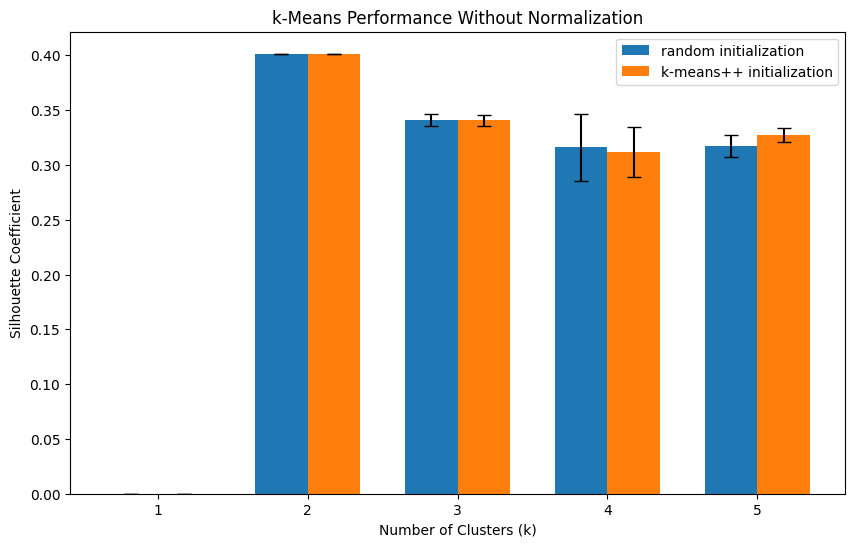

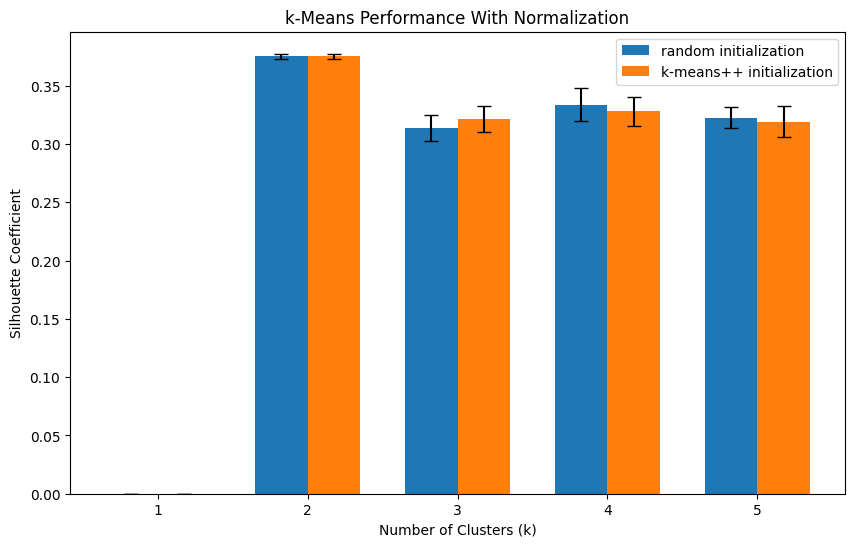

In [ ]:
# Plotting without normalization
plt.figure(figsize=(8, 6))
width = 0.35  # Width of the bars
x = np.arange(len(k_values))  # X-axis position for k values

for i, method in enumerate(init_methods):
    means = results_no_norm[method]['mean']
    stds = results_no_norm[method]['std']
    plt.bar(x + i * width, means, width, yerr=stds, capsize=5, label=f"{method} initialization")

plt.title("k-Means Performance Without Normalization")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Coefficient")
plt.xticks(x + width / 2, k_values)
plt.legend()
plt.show()

# Plotting with normalization
plt.figure(figsize=(8, 6))

for i, method in enumerate(init_methods):
    means = results_norm[method]['mean']
    stds = results_norm[method]['std']
    plt.bar(x + i * width, means, width, yerr=stds, capsize=5, label=f"{method} initialization")

plt.title("k-Means Performance With Normalization")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Coefficient")
plt.xticks(x + width / 2, k_values)
plt.legend()
plt.show()


## Q2 - Density-based clustering with DBSCAN

Function evaluate_dbscanfunction evaluates DBSCAN performance for a range of MinPts and Eps values.

For each combination of MinPts and Eps:
* Runs DBSCAN 10 times with random initializations.
* Computes the Silhouette Coefficient for the resulting clusters, ignoring
 cases where all points are labeled as noise (label -1).
* Records the mean and standard deviation of the Silhouette scores.

MinPts: The minimum number of points required to form a dense region, tested with values [5, 10, 15, 20].

Eps: The maximum distance between two points for them to be considered neighbors, tested with values [50, 100].

The results are stored in a dictionary with the Eps values as keys.
For each Eps value, the function records the mean and standard deviation of Silhouette scores for each MinPts value.


A bar plot is created to compare DBSCAN performance across different MinPts values for each Eps value.
Separate bars are plotted for each Eps value, differentiated by labels in the legend.

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# DBSCAN Evaluation
def evaluate_dbscan(X, min_pts_values, eps_values):
    results = {eps: {'mean': [], 'std': []} for eps in eps_values}

    for eps in eps_values:
        for min_pts in min_pts_values:
            silhouette_scores = []
            for _ in range(10):  # Run 10 random initializations
                dbscan = DBSCAN(eps=eps, min_samples=min_pts)
                labels = dbscan.fit_predict(X)

                # Ignore clustering results with noise (all -1)
                if len(np.unique(labels)) > 1:
                    score = silhouette_score(X, labels)
                    silhouette_scores.append(score)

            # Calculate mean and standard deviation
            if silhouette_scores:
                results[eps]['mean'].append(np.mean(silhouette_scores))
                results[eps]['std'].append(np.std(silhouette_scores))
            else:
                results[eps]['mean'].append(0)
                results[eps]['std'].append(0)
    return results

# Parameters for DBSCAN
min_pts_values = [5, 10, 15, 20]
eps_values = [50, 100]  # Updated eps values

# Evaluate DBSCAN performance
dbscan_results = evaluate_dbscan(X_np, min_pts_values, eps_values)

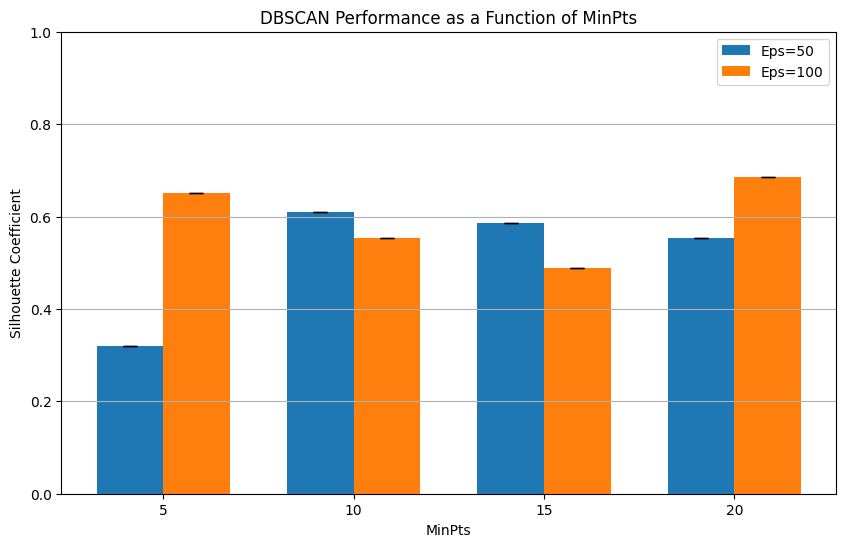

In [ ]:
# Plotting the results as a bar plot with error bars
bar_width = 0.35
x = np.arange(len(min_pts_values))  # X-axis positions for the MinPts values

plt.figure(figsize=(8, 6))

# Plot bars for each eps value
for i, eps in enumerate(eps_values):
    means = dbscan_results[eps]['mean']
    stds = dbscan_results[eps]['std']
    plt.bar(x + i * bar_width, means, bar_width, yerr=stds, capsize=5, label=f"Eps={eps}")

# Add plot labels, legend, and grid
plt.title("DBSCAN Performance as a Function of MinPts")
plt.xlabel("MinPts")
plt.ylabel("Silhouette Coefficient")
plt.xticks(x + bar_width / 2, min_pts_values)  # Center the xticks between bars
plt.ylim([0, 1])
plt.legend()
plt.grid(axis='y')
plt.show()


## Q3 - Graph-based clustering with Spectral Clustering

We implemented spectral clustering, a technique for grouping data points based on their similarity, and evaluates its performance using the Normalized Mutual Information (NMI) score.

We compted a similarity matrix using a Gaussian function, where distances between points are transformed into similarity values, and self-loops are removed.

A Laplacian matrix is derived from this similarity matrix to capture the graph structure of the data.

We performed eigenvalue decomposition to extract key eigenvectors, which represent the lower-dimensional embedding of the data. K-Means clustering is applied to these eigenvectors to assign points to clusters.

Finally, the clustering quality is evaluated for various combinations of cluster counts producing NMI scores to assess how well the clustering aligns with true labels.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse.linalg import eigsh
from numpy.linalg import eigh
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Gaussian Similarity Function
def gaussian_similarity(X, sigma):
    pairwise_sq_dists = pairwise_distances(X, metric='sqeuclidean')
    W = np.exp(-pairwise_sq_dists / (2 * sigma**2))
    np.fill_diagonal(W, 0)  # No self-loops
    return W

# Unnormalized Spectral Clustering
def spectral_clustering(X, k, sigma):
    W = gaussian_similarity(X, sigma)
    D = np.diag(W.sum(axis=1))
    L = D - W  # Unnormalized Laplacian

    # Check the Laplacian matrix
    if np.isnan(L).any() or np.isinf(L).any():
        raise ValueError("The Laplacian matrix contains NaN or infinite values!")

    try:
        # Sparse eigen decomposition
        eigenvalues, eigenvectors = eigsh(L, k=k, which='SM', maxiter=5000, tol=1e-4)
    except Exception as e:
        # print(f"Eigenvalue computation failed with error: {e}")
        # print("Using dense solver as fallback.")
        # Dense solver fallback (efficiently selects k smallest eigenvalues)
        eigenvalues, eigenvectors = eigh(L)
        idx = np.argsort(eigenvalues)[:k]
        eigenvectors = eigenvectors[:, idx]

    # K-means clustering on the eigenvectors
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
    labels = kmeans.fit_predict(eigenvectors)
    return labels

# Evaluate performance
def evaluate_performance(X, y, max_k, sigmas):
    scores = {sigma: [] for sigma in sigmas}
    for sigma in sigmas:
        for k in range(1, max_k + 1):
            labels = spectral_clustering(X, k, sigma)
            nmi = normalized_mutual_info_score(y, labels)
            scores[sigma].append(nmi)
    return scores

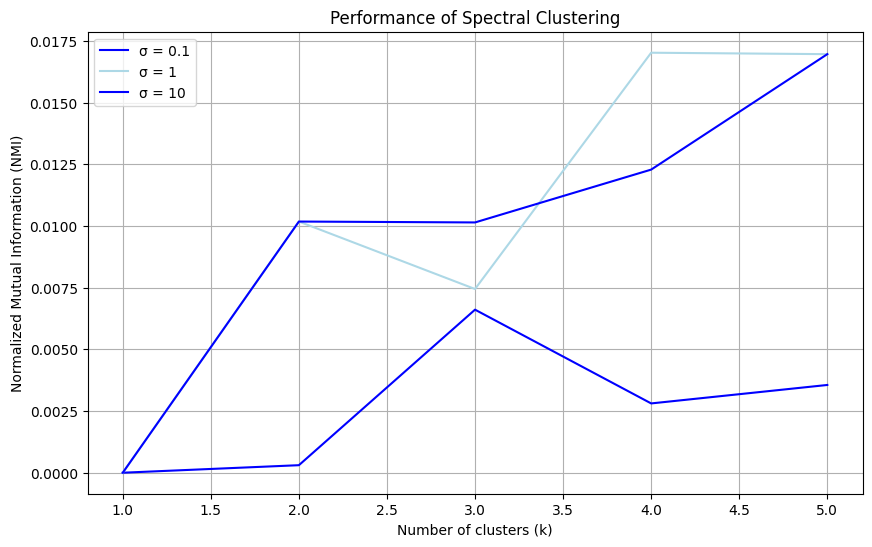

In [ ]:
# Plotting the results
def plot_performance(scores, max_k, sigmas):
    plt.figure(figsize=(10, 6))
    colors = ['blue', 'lightblue']
    for i, sigma in enumerate(sigmas):
        plt.plot(range(1, max_k + 1), scores[sigma], label=f"σ = {sigma}", color=colors[i % len(colors)])
    plt.title("Performance of Spectral Clustering")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Normalized Mutual Information (NMI)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Compute performance and plot
scores = evaluate_performance(X, y, max_k, sigmas)
plot_performance(scores, max_k, sigmas)


## Q4 - Anomaly detection with the Isolation Forest

Importing Libraries: We imported essential libraries like NumPy, Pandas, Isolation Forest (for anomaly detection), KMeans (for clustering), and StandardScaler (for data normalization) are imported.

Data Normalization: Then the dataset is scaled using StandardScaler to standardize features by removing the mean and scaling to unit variance.

Isolation Forest: An Isolation Forest model is trained on the normalized data to detect anomalies, with a contamination rate of 10% indicating the expected proportion of anomalies.

Anomaly Scores: We made a decision function of the Isolation Forest calculates scores indicating the degree of anomaly for each data point.

Threshold-Based Filtering: We used percentile thresholds (1%, 5%, 10%, 15%) to identify data points with scores above the threshold, effectively removing outliers/anomalies.

KMeans Clustering: The filtered data is clustered into two groups using the KMeans++ algorithm, which initializes centroids in a smarter way for faster convergence.

Results Storage: We then stored filtered datasets and their respective clustering  in a dictionary, results, keyed by the percentile threshold.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import silhouette_score


# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_forest.fit(X_scaled)
anomaly_scores = iso_forest.decision_function(X_scaled)

# Remove anomalies based on thresholds
percentiles = [1, 5, 10, 15]
results = {}
for pct in percentiles:
    threshold = np.percentile(anomaly_scores, pct)
    mask = anomaly_scores > threshold
    X_filtered = X_scaled[mask]

    # Perform KMeans++ clustering on the filtered data
    kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
    kmeans.fit(X_filtered)
    results[pct] = (X_filtered, kmeans.labels_)


# Compute performance metrics
performance_scores = {'Inertia': [], 'Silhouette': []}

for pct in percentiles:
    X_filtered, labels = results[pct]
    # KMeans clustering on filtered data
    kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42).fit(X_filtered)

    # Inertia (lower is better)
    inertia = kmeans.inertia_
    performance_scores['Inertia'].append(inertia)

    # Silhouette score (higher is better)
    if len(X_filtered) > 1:  # Avoid silhouette computation on too few samples
        silhouette = silhouette_score(X_filtered, kmeans.labels_)
        performance_scores['Silhouette'].append(silhouette)
    else:
        performance_scores['Silhouette'].append(np.nan)  # Handle edge cases


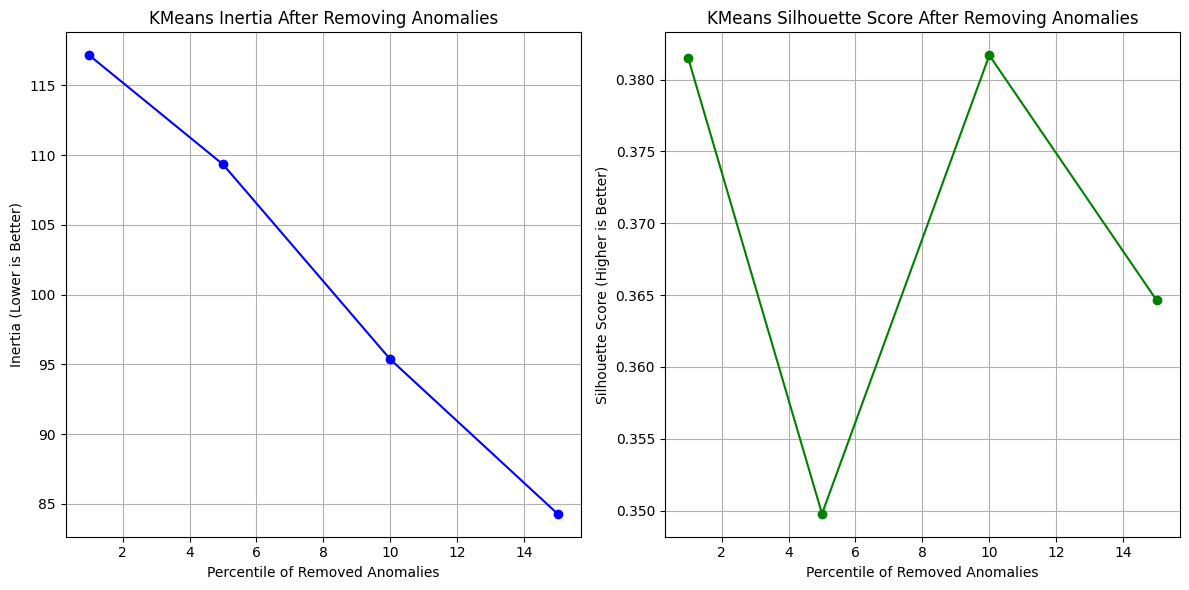

In [ ]:

# Plot performance
plt.figure(figsize=(12, 6))

# Inertia Plot
plt.subplot(1, 2, 1)
plt.plot(percentiles, performance_scores['Inertia'], marker='o', linestyle='-', color='blue')
plt.title('KMeans Inertia After Removing Anomalies')
plt.xlabel('Percentile of Removed Anomalies')
plt.ylabel('Inertia (Lower is Better)')
plt.grid(True)

# Silhouette Score Plot
plt.subplot(1, 2, 2)
plt.plot(percentiles, performance_scores['Silhouette'], marker='o', linestyle='-', color='green')
plt.title('KMeans Silhouette Score After Removing Anomalies')
plt.xlabel('Percentile of Removed Anomalies')
plt.ylabel('Silhouette Score (Higher is Better)')
plt.grid(True)

plt.tight_layout()
plt.show()


# References / Disclosures

[Add your references / disclosures for your implementations here]

Scikit-learn Documentation — official documentation for the IsolationForest and KMeans implementations.

Some towards data science blogs: https://towardsdatascience.com/isolation-forest-the-anomaly-detection-algorithm-any-data-scientist-should-know-1a99622eec2d

Research paper: https://ieeexplore.ieee.org/document/4781136

https://ieeexplore.ieee.org/document/4781136
